In [112]:
import sys
import os
from tensorflow.keras.models import load_model
import joblib
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_repo_age_days_col, add_days_since_last_release_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target, scale_final_data, remove_outliers, reduce_dimentionality_pca, forecast_growth, get_single_repo_data, remove_unwanted_features, distribute_features_across_releases, apply_time_based_noise, apply_proportional_noise, remove_first_augmented_rows
import numpy as np

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)
from config import GITHUB_TOKEN


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)



In [113]:
# https://github.com/AMAI-GmbH/AI-Expert-Roadmap # no releases
# https://github.com/vim-airline/vim-airline # not enough release dates
# https://github.com/salesforce/LAVIS # not enough releases
# https://github.com/numenta/nupic-legacy  # last release in 2018

# Repos with lots of releases:
# https://github.com/crewAIInc/crewAI
# https://github.com/tensorflow/tensorflow
# https://github.com/magenta/magenta # 48 releases
test_df = get_single_repo_data('https://github.com/magenta/magenta', GITHUB_TOKEN)

test_df.head(20)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,v2.1.4,2022-08-01T18:18:44Z,30,414,1140,19113,3738,19113
1,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,v2.1.2,2020-09-08T13:05:49Z,30,414,1140,19113,3738,19113
2,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,v2.1.1,2020-08-17T19:59:13Z,30,414,1140,19113,3738,19113
3,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,2.1.0,2020-06-17T14:00:11Z,30,414,1140,19113,3738,19113
4,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,2.0.1,2020-06-03T01:28:55Z,30,414,1140,19113,3738,19113
5,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,2.0.0,2020-06-02T17:48:11Z,30,414,1140,19113,3738,19113
6,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,v1.3.2,2020-05-27T18:51:47Z,30,414,1140,19113,3738,19113
7,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,v1.3.0,2020-03-31T17:08:32Z,30,414,1140,19113,3738,19113
8,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,v1.2.2,2019-12-11T20:00:08Z,30,414,1140,19113,3738,19113
9,magenta,magenta,Magenta: Music and Art Generation with Machine...,https://github.com/magenta/magenta,,2016-05-05T20:10:40Z,2024-09-29T06:56:39Z,v1.2.1,2019-12-10T19:28:43Z,30,414,1140,19113,3738,19113


In [114]:
if (test_df['num_releases'] <= 12).any():
    print('please provide a repos with more than 5 releases')


df_exploded = test_df 
df_exploded = df_exploded.sort_values(by='release_date', ascending=True).reset_index(drop=True)

df_augmented = distribute_features_across_releases(df_exploded, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues', 'num_releases'])
df_augmented = apply_time_based_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = apply_proportional_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = remove_first_augmented_rows(df_augmented)
df_augmented = add_growth_score_based_on_main_features(df_augmented, train=False)
actual_growth_score = df_augmented['growth_score']

test_df = df_augmented
test_df = add_repo_age_days_col(test_df)
test_df = add_days_since_last_release_col(test_df)
test_df = convert_topics_to_embeddings(test_df)
test_df = remove_outliers(test_df)
test_df = indexify_release_dates(test_df)

n_lag_features = 4
n_timesteps = 3

test_df = add_lag_features_based_on_target(test_df, num=n_lag_features)

print(actual_growth_score)
print("Last historical date:", test_df.index[-1])

/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['growth_score'] = scaled_features.sum(axis=1)
/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['creation_date'] = pd.to_datetime(df['creation_date'])
/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:255: SettingWithCopyWarn

0     0.056643
1     0.142212
2     0.218899
3     0.307673
4     0.372734
5     0.448669
6     0.496098
7     0.556057
8     0.602514
9     0.635843
10    0.677204
11    0.676739
12    0.689577
13    0.719452
14    0.753050
15    0.763388
16    0.780716
17    0.791348
18    0.793841
19    0.813942
20    0.838234
21    0.873193
22    0.919549
23    0.966108
24    1.012643
25    1.081626
26    1.154130
27    1.231911
28    1.309877
Name: growth_score, dtype: float64
Last historical date: 2022-08-01 18:18:44+00:00


/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_embedding'] = df['topics'].apply(lambda topic: sentence_embeddings_model.encode(topic))


In [115]:
print('test_df.shape', test_df.shape)
X = remove_unwanted_features(test_df)
print(X.shape)
X_scaled = scale_final_data(X=X.values)
X_scaled_pca = reduce_dimentionality_pca(X_scaled)

n_features_pca = X_scaled_pca.shape[1]

print(X_scaled_pca.shape[1], n_features_pca)
test_generator = TimeseriesGenerator(X_scaled_pca, np.zeros(len(X_scaled_pca)), length=n_timesteps, batch_size=1)

model = load_model('../models/best_rnn_model.keras')

print(X_scaled_pca.shape[0])
print(model.summary())

y_pred = model.predict(test_generator)
print(f'predicted: {y_pred}', f' | actual: {actual_growth_score}')

test_df.shape (25, 403)
(25, 396)
126 126
25


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 3, 126)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_39 (GRU)        │ (None, 3, 64)     │     36,864 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 3, 64)     │          0 │ gru_39[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_39        │ (None, 3, 64)     │          0 │ dropout_78[0][0], │
│ (Attention)         │                   │            │ dropout_78[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 3, 64)     │          0 │ dropout_78[0][0], │
│                     │                   │            │ attention_39[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 64)     │        128 │ add_39[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_39         │ (None, 64)        │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 64)        │      4,160 │ get_item_39[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 64)        │          0 │ dense_78[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 1)         │         65 │ dropout_79[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,653 (483.02 KB)

 Trainable params: 41,217 (161.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,436 (322.02 KB)

None
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
predicted: [[0.4401506 ]
 [0.44013396]
 [0.44011334]
 [0.43861568]
 [0.39781618]
 [0.37744448]
 [0.36670277]
 [0.36562803]
 [0.36284366]
 [0.36284363]
 [0.36284363]
 [0.36284357]
 [0.36284357]
 [0.36284357]
 [0.36284357]
 [0.36284357]
 [0.36284357]
 [0.36284357]
 [0.36284357]
 [0.36284357]
 [0.36284357]
 [0.36284357]]  | actual: 0     0.056643
1     0.142212
2     0.218899
3     0.307673
4     0.372734
5     0.448669
6     0.496098
7     0.556057
8     0.602514
9     0.635843
10    0.677204
11    0.676739
12    0.689577
13    0.719452
14    0.753050
15    0.763388
16    0.780716
17    0.791348
18    0.793841
19    0.813942
20    0.838234
21    0.873193
22    0.919549
23    0.966108
24    1.012643
25    1.081626
26    1.154130
27    1.231911
28    1.309877
Name: growth_score, dtype: float64


In [116]:
# Use a few sample values from the actual data 
# just for sanity check to make sure the scaler is working correctly
sample_data = np.array([[0.3], [0.5], [0.7], [1.0], [1.2]])

scaler_y = joblib.load('../models/final_target_scaler.pkl')
scaled_data = scaler_y.transform(sample_data)
inverse_scaled_data = scaler_y.inverse_transform(scaled_data)

print("Original Data:\n", sample_data)
print("Scaled Data:\n", scaled_data)
print("Inverse Scaled Data:\n", inverse_scaled_data)

Original Data:
 [[0.3]
 [0.5]
 [0.7]
 [1. ]
 [1.2]]
Scaled Data:
 [[0.28974655]
 [0.48291092]
 [0.67607529]
 [0.96582185]
 [1.15898621]]
Inverse Scaled Data:
 [[0.3]
 [0.5]
 [0.7]
 [1. ]
 [1.2]]


In [117]:
n_forecast_steps = 12 
scaler_y = joblib.load('../models/final_target_scaler.pkl')
print("Scaler data min:", scaler_y.data_min_)
print("Scaler data max:", scaler_y.data_max_)
print("Scaler feature range:", scaler_y.feature_range)


initial_data = X_scaled_pca[-n_timesteps:]
print(initial_data.shape)
print("Number of features in X_scaled_pca:", X_scaled_pca.shape[1])


# Perform the forecasting
forecasted_values = forecast_growth(
    model=model, 
    initial_data=initial_data, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=n_timesteps,
    n_features=n_features_pca
)

print("Forecasted Growth Scores:", forecasted_values)

Scaler data min: [0.]
Scaler data max: [1.03538764]
Scaler feature range: (0, 1)
(3, 126)
Number of features in X_scaled_pca: 126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Forecasted Growth Scores: [0.37568375 0.37568375 0.37568375 0.37568375 0.37568375 0.37568375
 0.37568375 0.37568375 0.37568375 0.37568375 0.37568375 0.37568375]


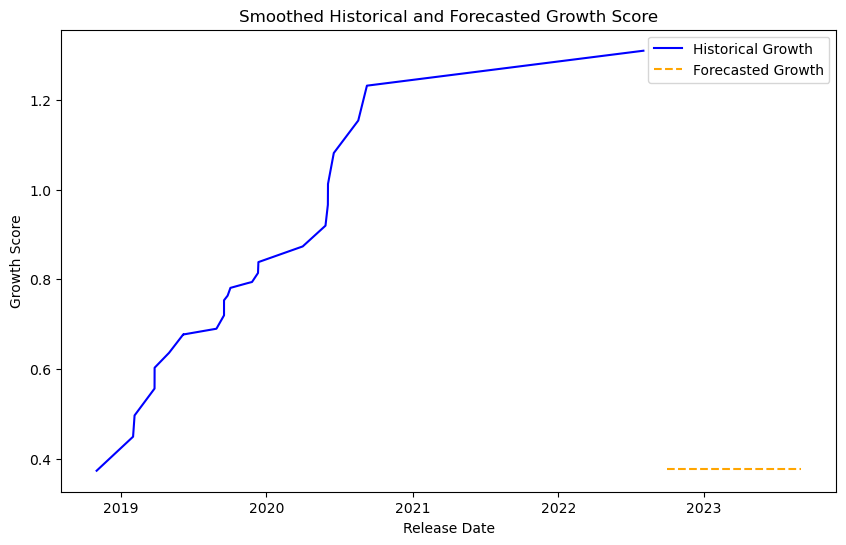

In [118]:
import pandas as pd
# Generate future dates for the forecasted values based on the release_date index by Monthly frequency
forecasted_dates = pd.date_range(start=test_df.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]

plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['growth_score'], color='blue', label='Historical Growth')
plt.plot(forecasted_dates, forecasted_values, color='orange', linestyle='--', label='Forecasted Growth')


plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Smoothed Historical and Forecasted Growth Score')
plt.legend()
plt.show()

In [119]:
forecasted_values

array([0.37568375, 0.37568375, 0.37568375, 0.37568375, 0.37568375,
       0.37568375, 0.37568375, 0.37568375, 0.37568375, 0.37568375,
       0.37568375, 0.37568375], dtype=float32)